# **Movie Rating Prediction**

In [812]:
import warnings
warnings.simplefilter(action = "ignore")

## Data Exploration

In [813]:
import numpy as np
import pandas as pd

movies_data = pd.read_csv('data_scrapped/imdb-movies-dataset.csv')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

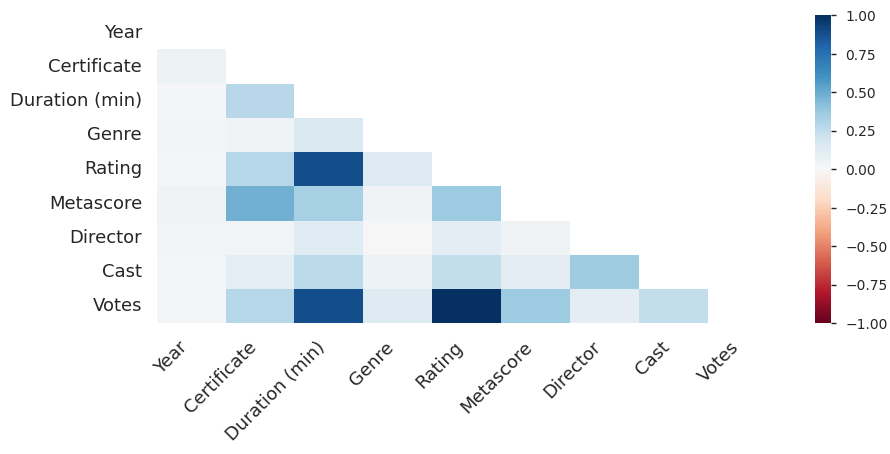

In [814]:
from ydata_profiling import ProfileReport
ProfileReport(movies_data, title="Profiling Report")

## Data Preprocessing

In [815]:
cleaned_data = movies_data.drop(['Description', 'Title', 'Metascore'], axis=1)
cleaned_data['Votes'] = cleaned_data['Votes'].str.replace(',','').astype(float)

In [816]:
cleaned_data.fillna({
    'Year': cleaned_data['Year'].mean(),
    'Certificate': cleaned_data['Certificate'].mode()[0],
    'Duration (min)': cleaned_data['Duration (min)'].mean(),
    'Genre': cleaned_data['Genre'].mode()[0],
    'Rating': cleaned_data['Rating'].mean(),
    'Director': cleaned_data['Director'].mode()[0],
    'Cast': cleaned_data['Cast'].mode()[0],
    'Votes': cleaned_data['Votes'].mean(),
    }, inplace=True
)

In [817]:
cleaned_data['Genre'] = cleaned_data['Genre'].str.split(', ')
cleaned_data = cleaned_data.explode('Genre')

## Data Visualization

In [818]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [819]:
fig = px.pie(cleaned_data, values='Votes', names='Genre', hover_data=['Genre'])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title='Distribution of Movie Genres')
fig.show()

In [820]:
fig = px.area(cleaned_data, x='Year', y='Votes', hover_data=['Votes', 'Year'])
fig.update_layout(
    title='Voting Trends Over the Years',
    xaxis_title="Year",
    yaxis_title="Total Votes", 
)
fig.show()

In [821]:
director_stats = cleaned_data.groupby('Director').agg({'Rating': 'mean', 'Votes': 'sum'})
top_n_directors = director_stats.nlargest(30, 'Rating')

fig = px.bar(top_n_directors, x=top_n_directors.index, y='Rating',
             color='Rating',
             labels={'Rating': 'Average Rating', 'Director': 'Director'},
             title='Top 30 Directors by Average Rating')
fig.update_traces(hovertemplate='<b>%{x}</b><br>Average Rating: %{y:.1f}')
fig.show()

## Feature Engineering

In [822]:
cleaned_data['encoded_Genre'] = cleaned_data.groupby('Genre')['Rating'].transform('mean')
cleaned_data['encoded_Duration'] = cleaned_data.groupby('Duration (min)')['Rating'].transform('mean')
cleaned_data['encoded_Certificate'] = cleaned_data.groupby('Certificate')['Rating'].transform('mean')
cleaned_data['encoded_Director'] = cleaned_data.groupby('Director')['Rating'].transform('mean')

In [829]:
cleaned_data.drop(['Certificate', 'Genre', 'Director', 'Cast', ], axis=1).corr()

Year  Duration (min)    Rating     Votes  \
Year                 1.000000        0.000048  0.013744  0.029203   
Duration (min)       0.000048        1.000000  0.353649  0.231671   
Rating               0.013744        0.353649  1.000000  0.379405   
Votes                0.029203        0.231671  0.379405  1.000000   
encoded_Genre       -0.001970        0.192718  0.271214 -0.025928   
encoded_Duration    -0.002896        0.838661  0.421683  0.276916   
encoded_Certificate  0.033984        0.120855  0.188175  0.318879   
encoded_Director     0.010684        0.348579  0.845957  0.262673   

                     encoded_Genre  encoded_Duration  encoded_Certificate  \
Year                     -0.001970         -0.002896             0.033984   
Duration (min)            0.192718          0.838661             0.120855   
Rating                    0.271214          0.421683             0.188175   
Votes                    -0.025928          0.276916             0.318879   
encoded_Genre             1.000000          0.208078            -0.032931   
encoded_Duration          0.208078          1.000000             0.145474   
encoded_Certificate      -0.032931          0.145474             1.000000   
encoded_Director          0.253603          0.410872             0.168041   

                     encoded_Director  
Year                         0.010684  
Duration (min)               0.348579  
Rating                       0.845957  
Votes                        0.262673  
encoded_Genre                0.253603  
encoded_Duration             0.410872  
encoded_Certificate          0.168041  
encoded_Director             1.000000

## Model Building

In [824]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [825]:
X = cleaned_data[['Votes', 'encoded_Certificate', 'encoded_Duration', 'encoded_Genre', 'encoded_Director']]
y = cleaned_data['Rating']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2)

### **Support Vector Regresssion (SVR)**

In [830]:
svr = SVR(kernel='rbf') 
svr.fit(X_train, y_train) 

SVR()

In [831]:
svr_pred = svr.predict(X_test)
print(f"Mean squared error: {mean_squared_error(y_test, svr_pred)}")
print(f"R2 score: {r2_score(y_test, svr_pred)}")

Mean squared error: 0.8670833163509086
R2 score: 0.18298258486640184


### **Decision Tree Regression Model**

In [832]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [833]:
dt_pred = dt.predict(X_test)
print(f"Mean squared error: {mean_squared_error(y_test, dt_pred)}")
print(f"R2 score: {r2_score(y_test, dt_pred)}")

Mean squared error: 0.18236823691296045
R2 score: 0.8281618124632454


### **Random Forest Regression Model**

In [834]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [835]:
rf_pred = rf.predict(X_test)
print(f"Mean squared error: {mean_squared_error(y_test, rf_pred)}")
print(f"R2 score: {r2_score(y_test, rf_pred)}")

Mean squared error: 0.10708027138605673
R2 score: 0.8991026065317183


## **Model Evaluation: Prediction on New Data**

In [836]:
test_data = {'Certificate':'PG-13', 'Votes': [3458], 'Duration (min)': 172.0, 'Genre': 'Comedy', 'Director': 'David Winters'}

In [837]:
test_data["encoded_Certificate"] = cleaned_data[cleaned_data['Certificate'] == test_data['Certificate']]['Rating'].iloc[0]
test_data["encoded_Duration"] = cleaned_data[cleaned_data['Duration (min)'] == test_data['Duration (min)']]['Rating'].iloc[0]
test_data["encoded_Genre"] = cleaned_data[cleaned_data['Genre'] == test_data['Genre']]['Rating'].iloc[0]
test_data['encoded_Director'] = cleaned_data[cleaned_data['Director'] == test_data['Director']]['Rating'].iloc[0]

In [838]:
df_test = pd.DataFrame(test_data)
df_test.drop(['Certificate', 'Duration (min)', 'Genre', 'Director'], axis = 1, inplace = True)
df_test

Votes  encoded_Certificate  encoded_Duration  encoded_Genre  \
0   3458                  7.3               8.2            6.4   

   encoded_Director  
0               6.5

In [839]:
predicted_rating_svr = svr.predict(df_test)
print(f"Predicted Rating: {predicted_rating_svr[0]}")

Predicted Rating: 6.0344102576761705


In [840]:
predicted_rating_dt = dt.predict(df_test)
print(f"Predicted Rating: {predicted_rating_dt[0]}")

Predicted Rating: 8.0


In [841]:
predicted_rating_rf = rf.predict(df_test)
print(f"Predicted Rating: {predicted_rating_rf[0]}")

Predicted Rating: 7.408400229357799
